### Dataset

In [1]:
import pandas as pd

df = pd.read_csv('PubMed_CleanArticles_Top10_cancerTypes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   PUMID          10000 non-null  int64 
 1   Title          10000 non-null  object
 2   Article        10000 non-null  object
 3   Clean Article  10000 non-null  object
 4   Target Label   10000 non-null  int64 
 5   Target Name    10000 non-null  object
dtypes: int64(2), object(4)
memory usage: 468.9+ KB


In [2]:
df.head()

,PUMID,Title,Article,Clean Article,Target Label,Target Name
0,17078348,Understanding the symptoms experienced by indi...,Understanding the symptoms experienced by indi...,understand symptom experience individual lung ...,1,Lung
1,30206083,Do statins improve outcomes for patients with ...,Do statins improve outcomes for patients with ...,statin improve outcome patient non small cell ...,1,Lung
2,22974775,"Lung cancer epidemiology, risk factors, and pr...","Lung cancer epidemiology, risk factors, and pr...",lung cancer epidemiology risk factor preventio...,1,Lung
3,26299737,[Modern Nanomedicine in Treatment of Lung Carc...,[Modern Nanomedicine in Treatment of Lung Carc...,modern nanomedicine treatment lung carcinomas ...,1,Lung
4,8815254,[Nineteen multiple primary cancer cases of 100...,[Nineteen multiple primary cancer cases of 100...,nineteen multiple primary cancer case patient ...,1,Lung


In [3]:
df = df[['PUMID', 'Title', 'Clean Article', 'Target Label', 'Target Name']]
# df.tagline.fillna('', inplace=True)
# df['description'] = df['tagline'].map(str) + ' ' + df['overview']
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   PUMID          10000 non-null  int64 
 1   Title          10000 non-null  object
 2   Clean Article  10000 non-null  object
 3   Target Label   10000 non-null  int64 
 4   Target Name    10000 non-null  object
dtypes: int64(2), object(3)
memory usage: 468.8+ KB


In [4]:
df.head()

,PUMID,Title,Clean Article,Target Label,Target Name
0,17078348,Understanding the symptoms experienced by indi...,understand symptom experience individual lung ...,1,Lung
1,30206083,Do statins improve outcomes for patients with ...,statin improve outcome patient non small cell ...,1,Lung
2,22974775,"Lung cancer epidemiology, risk factors, and pr...",lung cancer epidemiology risk factor preventio...,1,Lung
3,26299737,[Modern Nanomedicine in Treatment of Lung Carc...,modern nanomedicine treatment lung carcinomas ...,1,Lung
4,8815254,[Nineteen multiple primary cancer cases of 100...,nineteen multiple primary cancer case patient ...,1,Lung


### Text Preprocessing

In [5]:
import nltk
import re
import numpy as np

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['Clean Article']))
len(norm_corpus)

10000

### Extract TF-IDF Features

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# stop_words = stop_words + ['one', 'two', 'get']
cv = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(10000, 15666)

### Cluster using K-Means

In [8]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 10
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=16, n_jobs=-1).fit(cv_matrix)
km

C:\Users\timot\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(max_iter=10000, n_clusters=10, n_init=50, n_jobs=-1, random_state=16)

In [9]:
from collections import Counter
df['kmeans_cluster'] = km.labels_
cn_kmeans_tfidf = Counter(km.labels_)
cn_kmeans_tfidf.most_common(10)

[(7, 1102),
 (2, 1011),
 (9, 998),
 (3, 998),
 (1, 993),
 (6, 989),
 (8, 985),
 (5, 984),
 (0, 979),
 (4, 961)]

# Question 1

## Select one articel (using "PUMID"), instead of using'popularity', from each cluster and extract top 5 similiarest articels (instances)) and tell what kind of the relationship among that articles and those 10 clusters you can observe.
## (70%) Repeat the processes of "K-Means" ( "NUM_CLUSTERS = 10") 

In [10]:
# Calculate Cosine
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_features = cosine_similarity(cv_matrix)

In [47]:
import heapq
from IPython.display import display
for i in range(10):
    temp = df[df['kmeans_cluster'] == i]
    pumid_rand = temp['PUMID'].sample(n=1, random_state=16).values
    sampled_pumid = df[df['PUMID'] == int(pumid_rand)][['PUMID','Title','Target Name', 'Target Label','kmeans_cluster']]
    i+=1
    print('\n'+ '\n' +'#'*56 + (' CLUSTER %d ' % i) + '#' *56 )
    display(sampled_pumid)
    
    tmp = cosine_sim_features[sampled_pumid.index][0]
    largest_idx = heapq.nlargest(6, range(len(tmp)), key=tmp.__getitem__)
    largest_idx.remove(sampled_pumid.index)
    
    df_temp = pd.DataFrame()
    for i in largest_idx:
        sampled_pumid = df[df.index == i][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']]
        df_temp = pd.concat([df_temp, sampled_pumid])
    display(df_temp)
    print('\n'+'#'*123)



######################################################## CLUSTER 1 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
491,28821979,The prognostic impact of combined pulmonary fi...,Lung,1,0


,PUMID,Title,Target Name,Target Label,kmeans_cluster
694,22152696,[Advances of treatment about elderly clinical ...,Lung,1,0
964,10355567,What is the role of radiation therapy in local...,Lung,1,0
627,24310811,MACC1 overexpression predicts a poor prognosis...,Lung,1,0
971,21162914,[Study of prognostic factors in patients with ...,Lung,1,0
844,19635204,[Influence of chronic obstructive pulmonary di...,Lung,1,0



###########################################################################################################################


######################################################## CLUSTER 2 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
1223,26231096,Race/ethnicity and socio-economic differences ...,Breast,2,1


,PUMID,Title,Target Name,Target Label,kmeans_cluster
1226,15282697,Jewish ethnicity and Black race: contrasting i...,Breast,2,1
1331,15252439,Asian/Pacific Islander American women: age and...,Breast,2,1
1646,21604959,Health-related quality of life among women wit...,Breast,2,1
7926,31645426,Creation of a Y-shaped ileal orthotopic neobla...,Cervix Uteri,8,9
1514,3280533,Is there a role for post-operative adjuvant ra...,Breast,2,1



###########################################################################################################################


######################################################## CLUSTER 3 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
2507,22333633,[Significance of Onodera's prognostic nutritio...,Colorectal,3,2


,PUMID,Title,Target Name,Target Label,kmeans_cluster
2762,19069689,Diagnosis and management of recurrent colorect...,Colorectal,3,2
2931,9033474,Generating evidence of a reduction in colorect...,Colorectal,3,2
4454,22965702,Malignant gastric cancer cured by short-term c...,Stomach,5,6
2547,24176190,[Treatment of colorectal cancer with unresecta...,Colorectal,3,2
2019,26348401,Reply to Screening for colorectal cancer in Ta...,Colorectal,3,2



###########################################################################################################################


######################################################## CLUSTER 4 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
3221,12622042,Prostate cancer treatment offers growth opport...,Prostate,4,3


,PUMID,Title,Target Name,Target Label,kmeans_cluster
3533,11980026,[CAT Scan in hormone-independent prostate canc...,Prostate,4,3
3708,29712494,Chromogranin A as a biomarker for prostate can...,Prostate,4,3
3401,26666105,LOW RISK PROSTATE CANCER: ACTIVE TREATMENT OR ...,Prostate,4,3
3310,27273379,Prostate cancer: Urology journals recommend ne...,Prostate,4,3
3534,11586206,Conservative management of prostate cancer in ...,Prostate,4,3



###########################################################################################################################


######################################################## CLUSTER 5 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
5481,8251308,Conformal high-dose radiation plus intraarteri...,Liver,6,4


,PUMID,Title,Target Name,Target Label,kmeans_cluster
5066,14648782,Conformal chemoradiation for primary and metas...,Liver,6,4
5340,11775441,Cryosurgery for primary and metastatic liver t...,Liver,6,4
5436,12777191,Impact of locoregional approaches to liver met...,Liver,6,4
5558,8508388,Surgical treatment of liver metastases in pati...,Liver,6,2
5917,23635782,Underlying potential: cellular and molecular d...,Liver,6,4



###########################################################################################################################


######################################################## CLUSTER 6 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
8144,19275510,Contemporary management of papillary carcinoma...,Thyroid,9,5


,PUMID,Title,Target Name,Target Label,kmeans_cluster
8965,31515127,Discussion.,Thyroid,9,5
8587,29032667,Synchronous parathyroid carcinoma and papillar...,Thyroid,9,5
8742,19247059,Extent of surgery affects papillary thyroid ca...,Thyroid,9,5
8681,29543059,Rising incidence of thyroid cancer in Singapor...,Thyroid,9,5
8880,26935705,"Expression, clinical significance and mechanis...",Thyroid,9,5



###########################################################################################################################


######################################################## CLUSTER 7 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
4980,31790410,Histo subtypes for gastric carcinoma and their...,Stomach,5,6


,PUMID,Title,Target Name,Target Label,kmeans_cluster
2891,29241727,Simple classifiers for molecular subtypes of c...,Colorectal,3,2
9824,28321693,"Age at diagnosis, obesity, smoking, and molecu...",Bladder,10,8
1612,26375671,Contrasting breast cancer molecular subtypes a...,Breast,2,1
7172,9987443,Automation of primary screening for cervical c...,Cervix Uteri,8,9
7846,21451154,Re: Preventing cervical cancer globally by act...,Cervix Uteri,8,9



###########################################################################################################################


######################################################## CLUSTER 8 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
6177,15361648,Carcinoma of the esophagus with mixed basaloid...,Oesophagus,7,7


,PUMID,Title,Target Name,Target Label,kmeans_cluster
9952,23433891,Squamous cell carcinogenesis and squamous cell...,Bladder,10,8
6249,28862264,SOX2-silenced squamous cell carcinoma: a highl...,Oesophagus,7,7
6573,6165519,Squamous cell carcinoma of the thoracic esopha...,Oesophagus,7,7
7270,13943724,[Considerations on the prognostic significance...,Cervix Uteri,8,9
7253,12060449,Immature glandular features in squamous cell c...,Cervix Uteri,8,9



###########################################################################################################################


######################################################## CLUSTER 9 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
9140,31144582,Management and outcome of TaG3 tumours of the ...,Bladder,10,8


,PUMID,Title,Target Name,Target Label,kmeans_cluster
9883,519209,Genetic association with bladder cancer.,Bladder,10,8
9730,16604997,"Superficial bladder cancer epidemiology, diagn...",Bladder,10,8
9559,29471601,[Bladder Rupture during Intravesical BCG Thera...,Bladder,10,8
9413,9666687,[The efficacy of re-TUR after 3 weeks of initi...,Bladder,10,8
9960,4651993,Specific induction of bladder cancer in mice b...,Bladder,10,8



###########################################################################################################################


######################################################## CLUSTER 10 ########################################################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
7218,20664421,ACOG Committee Opinion No. 463: Cervical cance...,Cervix Uteri,8,9


,PUMID,Title,Target Name,Target Label,kmeans_cluster
7149,3995858,Problems in the clinical recognition of cervic...,Cervix Uteri,8,9
7847,13091242,[Treatment of recurrent cervical cancer 1941-45].,Cervix Uteri,8,9
7597,22546780,HPV & age-appropriate cervical cancer preventi...,Cervix Uteri,8,9
7406,17999298,Cervical cancer in women aged less than 25: Ea...,Cervix Uteri,8,9
7260,1257395,Cancer screening in East Sussex.,Cervix Uteri,8,9



###########################################################################################################################


# Question 2

## Try to observe the results of above three clustering methods and compare the content of articelss within these 10 clusters if possible.
## (80%) (70%) + Compare "K-Means" with two different clustering method "Affinity Propagation" and "Ward clustering algorithm".

### Affinity Propagation

In [49]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(max_iter=1000)
ap.fit(cv_matrix)
df['affprop_cluster'] = ap.labels_
res = Counter(ap.labels_)
res.most_common(10)

C:\Users\timot\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


[(65, 126),
 (150, 94),
 (427, 81),
 (261, 64),
 (1137, 60),
 (659, 56),
 (1069, 51),
 (1081, 51),
 (70, 49),
 (853, 41)]

In [50]:
sample_title = Counter(df[df['affprop_cluster'] == mc[i][0]]['Target Name'])
sample_title.most_common(10)[0][0]

'Lung'


########################################## Word Cloud using Affinity Propagation ##########################################


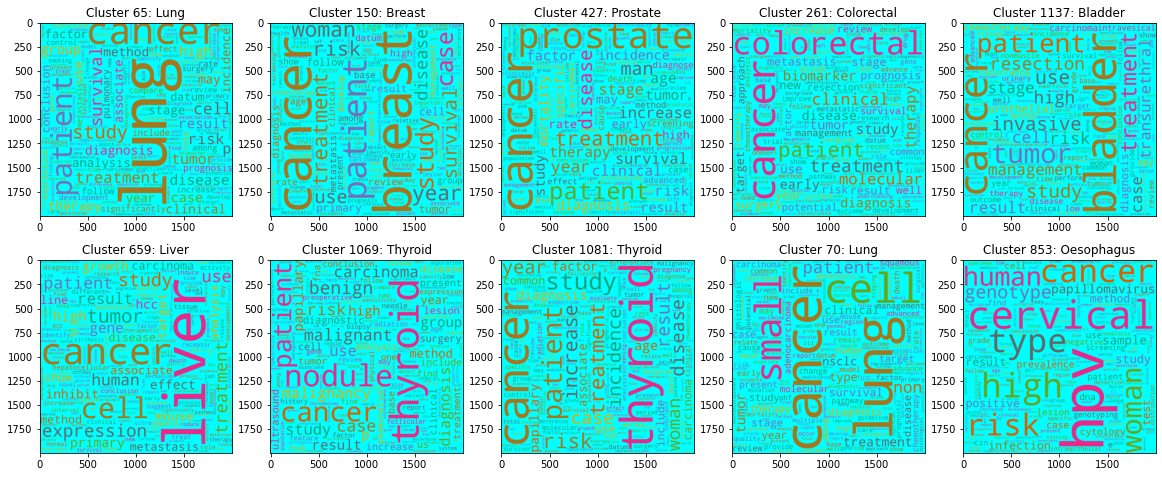

In [51]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
ls_wc, title_ap = [], []
mc = res.most_common(10)
for i in range(10):
    title = df[df['affprop_cluster'] == mc[i][0]]['Clean Article'].values
    title_ap.append(df[df['affprop_cluster'] == mc[i][0]]['Target Name'].values[0])
    text = str()
    for i in title:
        text += i
    wordcloud = WordCloud(width = 2000, height = 2000, random_state=69, background_color='cyan', colormap='Dark2', collocations=False, stopwords = STOPWORDS).generate(text)
    ls_wc.append(wordcloud)
    
f, axarr = plt.subplots(2,5, figsize=(20,8))
itr = 0
print('\n'+'#'*42+' Word Cloud using Affinity Propagation '+'#'*42)
for i in range(2):
    for j in range(5):
        axarr[i][j].set_title(('Cluster %d: ' % mc[itr][0]) + title_ap[itr])
        axarr[i][j].imshow(ls_wc[itr],cmap='gray')
        itr += 1

### KMeans Clustering

In [52]:
cn_kmeans_tfidf.most_common(10)

[(7, 1102),
 (2, 1011),
 (9, 998),
 (3, 998),
 (1, 993),
 (6, 989),
 (8, 985),
 (5, 984),
 (0, 979),
 (4, 961)]


########################################## Word Cloud using KMeans Clustering ##########################################


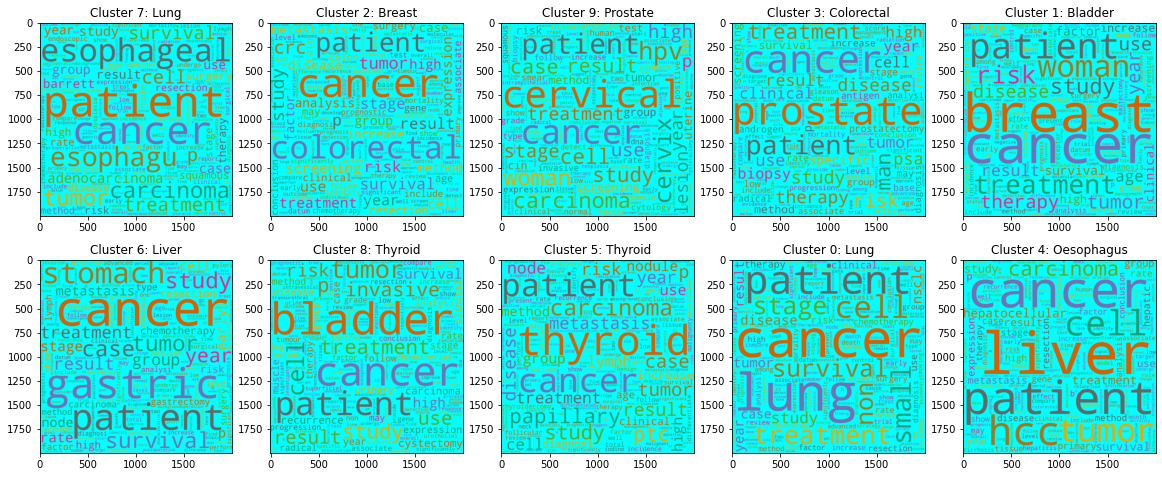

In [53]:
kmeans_mc = cn_kmeans_tfidf.most_common(10)
ls_wc_kmeans, title_km = [],[]

for i in range(10):
    title = df[df['kmeans_cluster'] == kmeans_mc[i][0]]['Clean Article'].values
    sample_title = Counter(df[df['kmeans_cluster'] == kmeans_mc[i][0]]['Target Name'])
    title_km.append(sample_title.most_common(10)[0][0])
    text = str()
    for i in title:
        text += i
    wordcloud = WordCloud(width = 2000, height = 2000, random_state=16, background_color='cyan', colormap='Dark2', collocations=False, stopwords = STOPWORDS).generate(text)
    ls_wc_kmeans.append(wordcloud)
    
f, axarr = plt.subplots(2,5, figsize=(20,8))
itr = 0
print('\n'+'#'*42+' Word Cloud using KMeans Clustering '+'#'*42)
for i in range(2):
    for j in range(5):
        axarr[i][j].set_title(('Cluster %d: ' % kmeans_mc[itr][0]) + title_ap[itr])
        axarr[i][j].imshow(ls_wc_kmeans[itr],cmap='gray')
        itr += 1

### Ward Clustering

In [54]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=10, linkage='ward')  
pred_label = cluster.fit_predict(cv_matrix.toarray())
df['ward_agglo_cluster'] = pred_label
# df
wd = Counter(cluster.labels_)
wd.most_common(10)

[(0, 4128),
 (4, 824),
 (2, 798),
 (5, 768),
 (7, 713),
 (6, 603),
 (3, 589),
 (8, 573),
 (1, 568),
 (9, 436)]


########################################## Word Cloud using Ward Clustering ##########################################


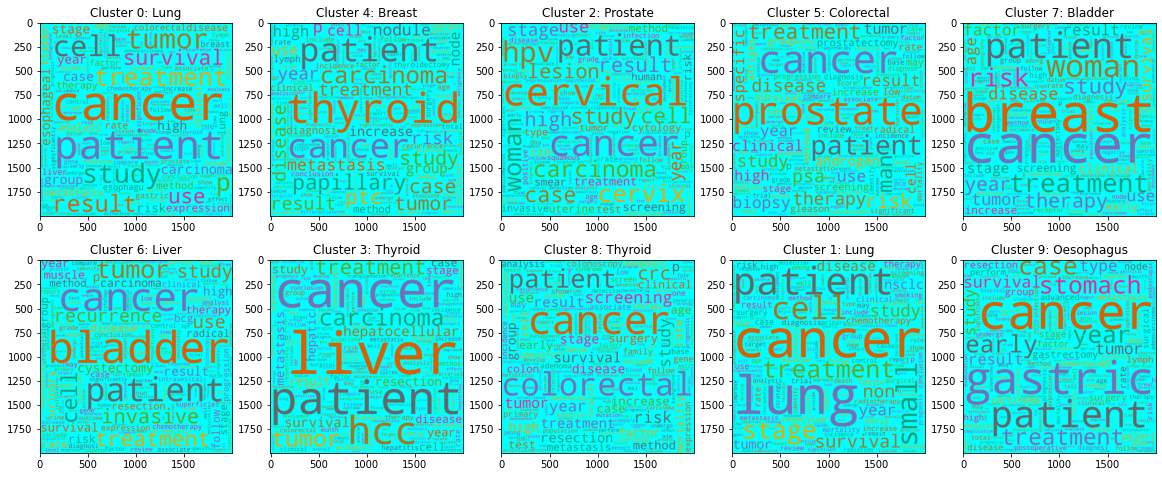

In [55]:
wd_mc = wd.most_common(10)
ls_wd_kmeans, title_wd = [],[]

for i in range(10):
    title = df[df['ward_agglo_cluster'] == wd_mc[i][0]]['Clean Article'].values
    sample_title = Counter(df[df['ward_agglo_cluster'] == wd_mc[i][0]]['Target Name'])
    title_wd.append(sample_title.most_common(10)[0][0])
    text = str()
    for i in title:
        text += i
    wordcloud = WordCloud(width = 2000, height = 2000, random_state=16, background_color='cyan', colormap='Dark2', collocations=False, stopwords = STOPWORDS).generate(text)
    ls_wd_kmeans.append(wordcloud)
    
f, axarr = plt.subplots(2,5, figsize=(20,8))
itr = 0
print('\n'+'#'*42+' Word Cloud using Ward Clustering '+'#'*42)
for i in range(2):
    for j in range(5):
        axarr[i][j].set_title(('Cluster %d: ' % wd_mc[itr][0]) + title_ap[itr])
        axarr[i][j].imshow(ls_wd_kmeans[itr],cmap='gray')
        itr += 1

# Question 3

## (90%) (80%) + Try to find one of missclassified instances of text classifications and evaluate its neighbor instances within the same cluster

In [62]:
sample = df[df['kmeans_cluster'] == 0]
sample_cn = Counter(sample['Target Label'])
# Find majority of target label
print('Target Label: ', sample_cn.most_common(10))

Target Label:  [(1, 971), (5, 3), (7, 3), (6, 2)]


In [64]:
# The correct target label is 1
sample[sample['Target Label'] == 1][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']].head(4)

,PUMID,Title,Target Name,Target Label,kmeans_cluster
0,17078348,Understanding the symptoms experienced by indi...,Lung,1,0
1,30206083,Do statins improve outcomes for patients with ...,Lung,1,0
2,22974775,"Lung cancer epidemiology, risk factors, and pr...",Lung,1,0
3,26299737,[Modern Nanomedicine in Treatment of Lung Carc...,Lung,1,0


In [65]:
missclassified_5 = sample[sample['Target Label'] == 5][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']]
missclassified_5

,PUMID,Title,Target Name,Target Label,kmeans_cluster
4095,23071999,[Upper G.I. cancer].,Stomach,5,0
4395,2847430,[The effectiveness of chemoradiotherapy of mal...,Stomach,5,0
4698,19020714,Blazein of a new steroid isolated from Agaricu...,Stomach,5,0


In [90]:
cosine_q3 = cosine_sim_features[missclassified_5.index[0]]

# original missclassified data
print('\n'+'#'*29+' Missclassified Stomach Data '+'#'*29)
display(missclassified_5[missclassified_5.index == missclassified_5.index[0]][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']])

largest_idx = heapq.nlargest(15, range(len(cosine_q3)), key=cosine_q3.__getitem__)
largest_idx.remove(missclassified_5.index[0])
idx_clean = []
for i in largest_idx:
    if i in sample.index:
        idx_clean.append(i)
df_temp = pd.DataFrame()
for i in idx_clean:
    sampled_pumid = df[df.index == i][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']]
    df_temp = pd.concat([df_temp, sampled_pumid])
print('\nThe neighbor :')
display(df_temp)


############################# Missclassified Stomach Data #############################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
4095,23071999,[Upper G.I. cancer].,Stomach,5,0



The neighbor :


,PUMID,Title,Target Name,Target Label,kmeans_cluster
643,23268091,[A successful treatment by surgery for axillar...,Lung,1,0
587,29587935,[The Argument and Consensus of Lymphadenectomy...,Lung,1,0
296,25252864,[Adenocarcinoma of lung cancer with solitary m...,Lung,1,0
438,21702251,The importance of smoking cessation as part of...,Lung,1,0
255,16685796,Clinical trials. Selected clinical trials in l...,Lung,1,0
543,14644530,Surgery in locally advanced non-small cell lun...,Lung,1,0
85,1847976,Unresectable stage III non-small-cell lung can...,Lung,1,0
737,16440683,[Surgical treatment for stage IV lung cancer].,Lung,1,0


In [70]:
missclassified_7 = sample[sample['Target Label'] == 7][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']]
missclassified_7

,PUMID,Title,Target Name,Target Label,kmeans_cluster
6234,25446726,Oesophageal cancer in 2014: Advances in curati...,Oesophagus,7,0
6321,1615268,How staging directs treatment for esophageal a...,Oesophagus,7,0
6922,6320389,[Influence of the localization on the prognost...,Oesophagus,7,0


In [91]:
cosine_q3 = cosine_sim_features[missclassified_7.index[0]]

# original missclassified data
print('\n'+'#'*28+' Misclassified Oesophagus Data '+'#'*28)
display(missclassified_7[missclassified_7.index == missclassified_7.index[0]][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']])

largest_idx = heapq.nlargest(15, range(len(cosine_q3)), key=cosine_q3.__getitem__)
largest_idx.remove(missclassified_7.index[0])
idx_clean = []
for i in largest_idx:
    if i in sample.index:
        idx_clean.append(i)
df_temp = pd.DataFrame()
for i in idx_clean:
    sampled_pumid = df[df.index == i][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']]
    df_temp = pd.concat([df_temp, sampled_pumid])
print('\nThe neighbor :')
display(df_temp)


############################ Misclassified Oesophagus Data ############################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
6234,25446726,Oesophageal cancer in 2014: Advances in curati...,Oesophagus,7,0



The neighbor :


,PUMID,Title,Target Name,Target Label,kmeans_cluster
355,26383980,[Research Progression of Maintenance Therapy i...,Lung,1,0
524,2848374,Non-surgical therapy of lung cancer--a critica...,Lung,1,0
539,23256734,Is vaccine therapy a renewed strategic approac...,Lung,1,0
724,225003,Relationship between survival and histologic t...,Lung,1,0
192,30347545,[Early diagnosis and treatmet of lung cancer: ...,Lung,1,0
593,10880943,[Preoperative chemotherapy for non-small-cell ...,Lung,1,0
351,14571014,Acute onset paraneoplastic cerebellar degenera...,Lung,1,0
257,20943619,Should we continue to use the term non-small-c...,Lung,1,0


In [74]:
missclassified_6 = sample[sample['Target Label'] == 6][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']]
missclassified_6

,PUMID,Title,Target Name,Target Label,kmeans_cluster
5639,27983936,Silencing of Btbd7 Inhibited Epithelial-Mesenc...,Liver,6,0
5887,22714079,[Surgical treatment of malignant lung tumors i...,Liver,6,0


In [92]:
cosine_q3 = cosine_sim_features[missclassified_6.index[0]]

# original missclassified data
print('\n'+'#'*30+' Misclassified Liver Data '+'#'*30)
display(missclassified_6[missclassified_6.index == missclassified_6.index[0]][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']])

largest_idx = heapq.nlargest(15, range(len(cosine_q3)), key=cosine_q3.__getitem__)
largest_idx.remove(missclassified_6.index[0])
idx_clean = []
for i in largest_idx:
    if i in sample.index:
        idx_clean.append(i)
df_temp = pd.DataFrame()
for i in idx_clean:
    sampled_pumid = df[df.index == i][['PUMID','Title','Target Name', 'Target Label', 'kmeans_cluster']]
    df_temp = pd.concat([df_temp, sampled_pumid])
print('\nThe neighbor :')
display(df_temp)


############################## Misclassified Liver Data ##############################


,PUMID,Title,Target Name,Target Label,kmeans_cluster
5639,27983936,Silencing of Btbd7 Inhibited Epithelial-Mesenc...,Liver,6,0



The neighbor :


,PUMID,Title,Target Name,Target Label,kmeans_cluster
39,24549856,Lung cancer stem cells and implications for fu...,Lung,1,0
